In [1]:
import os
import plotly.express as px
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import numpy as np



In [2]:
# ALL Data source files
path = "data/"
dir_list = os.listdir(path)
for i, name in enumerate(dir_list):
    print(f"{i}) {name}")

0) SOL-USD_1d_2024-01-01-2024-12-31_116_feature


In [3]:
# SELECT Data Source file name
dsn: str = 'SOL-USD_1d_2024-01-01-2024-12-31_116_feature' # Select data source name

In [4]:
data: pd.DataFrame = pd.read_csv(f"data/{dsn}")
data = data.set_index("datetime")

features = [i for i in data.columns if not i.startswith("y_")]
targets = [i for i in data.columns if i.startswith("y_")]


In [5]:
for idx, i in enumerate(features):
    print(f"{idx}. {i}")

0. close
1. high
2. low
3. open
4. volume
5. year
6. month
7. day
8. hour
9. minute
10. shift_1
11. shift_2
12. shift_3
13. shift_4
14. shift_5
15. shift_6
16. shift_7
17. mean
18. median
19. sum
20. min
21. max
22. std
23. diff_1
24. diff_2
25. diff_3
26. diff_4
27. diff_5
28. diff_6
29. diff_7
30. pct_1
31. pct_2
32. pct_3
33. pct_4
34. pct_5
35. pct_6
36. pct_7
37. prev_tick_trend
38. prev_tick_trend_sum_2
39. prev_tick_trend_sum_3
40. prev_tick_trend_sum_4
41. prev_tick_trend_sum_5
42. prev_tick_trend_sum_6
43. prev_tick_trend_sum_7
44. close_open_rel
45. close_high_rel
46. close_low_rel
47. open_close_spread
48. high_low_spread
49. ohlc_mean
50. diff_volume_1
51. diff_volume_2
52. diff_volume_3
53. diff_volume_4
54. diff_volume_5
55. diff_volume_6
56. diff_volume_7
57. camarilla_h1
58. camarilla_h2
59. camarilla_h3
60. camarilla_h4
61. camarilla_h5
62. camarilla_L1
63. camarilla_L2
64. camarilla_L3
65. camarilla_L4
66. camarilla_L5
67. market_turnover
68. diff_market_turnover_1
69

In [6]:
targets

['y_next_trend']

** Mutual info score **
market_turnover_pct_7    0.051919
diff_1                   0.051911
camarilla_L1             0.048452
close_low_rel            0.045795
bollinger_middle         0.044927
min                      0.044511
pct_7                    0.044352
prev_tick_trend_sum_4    0.040937
max                      0.039821
log_high                 0.038325
Name: MI Scores, dtype: float64


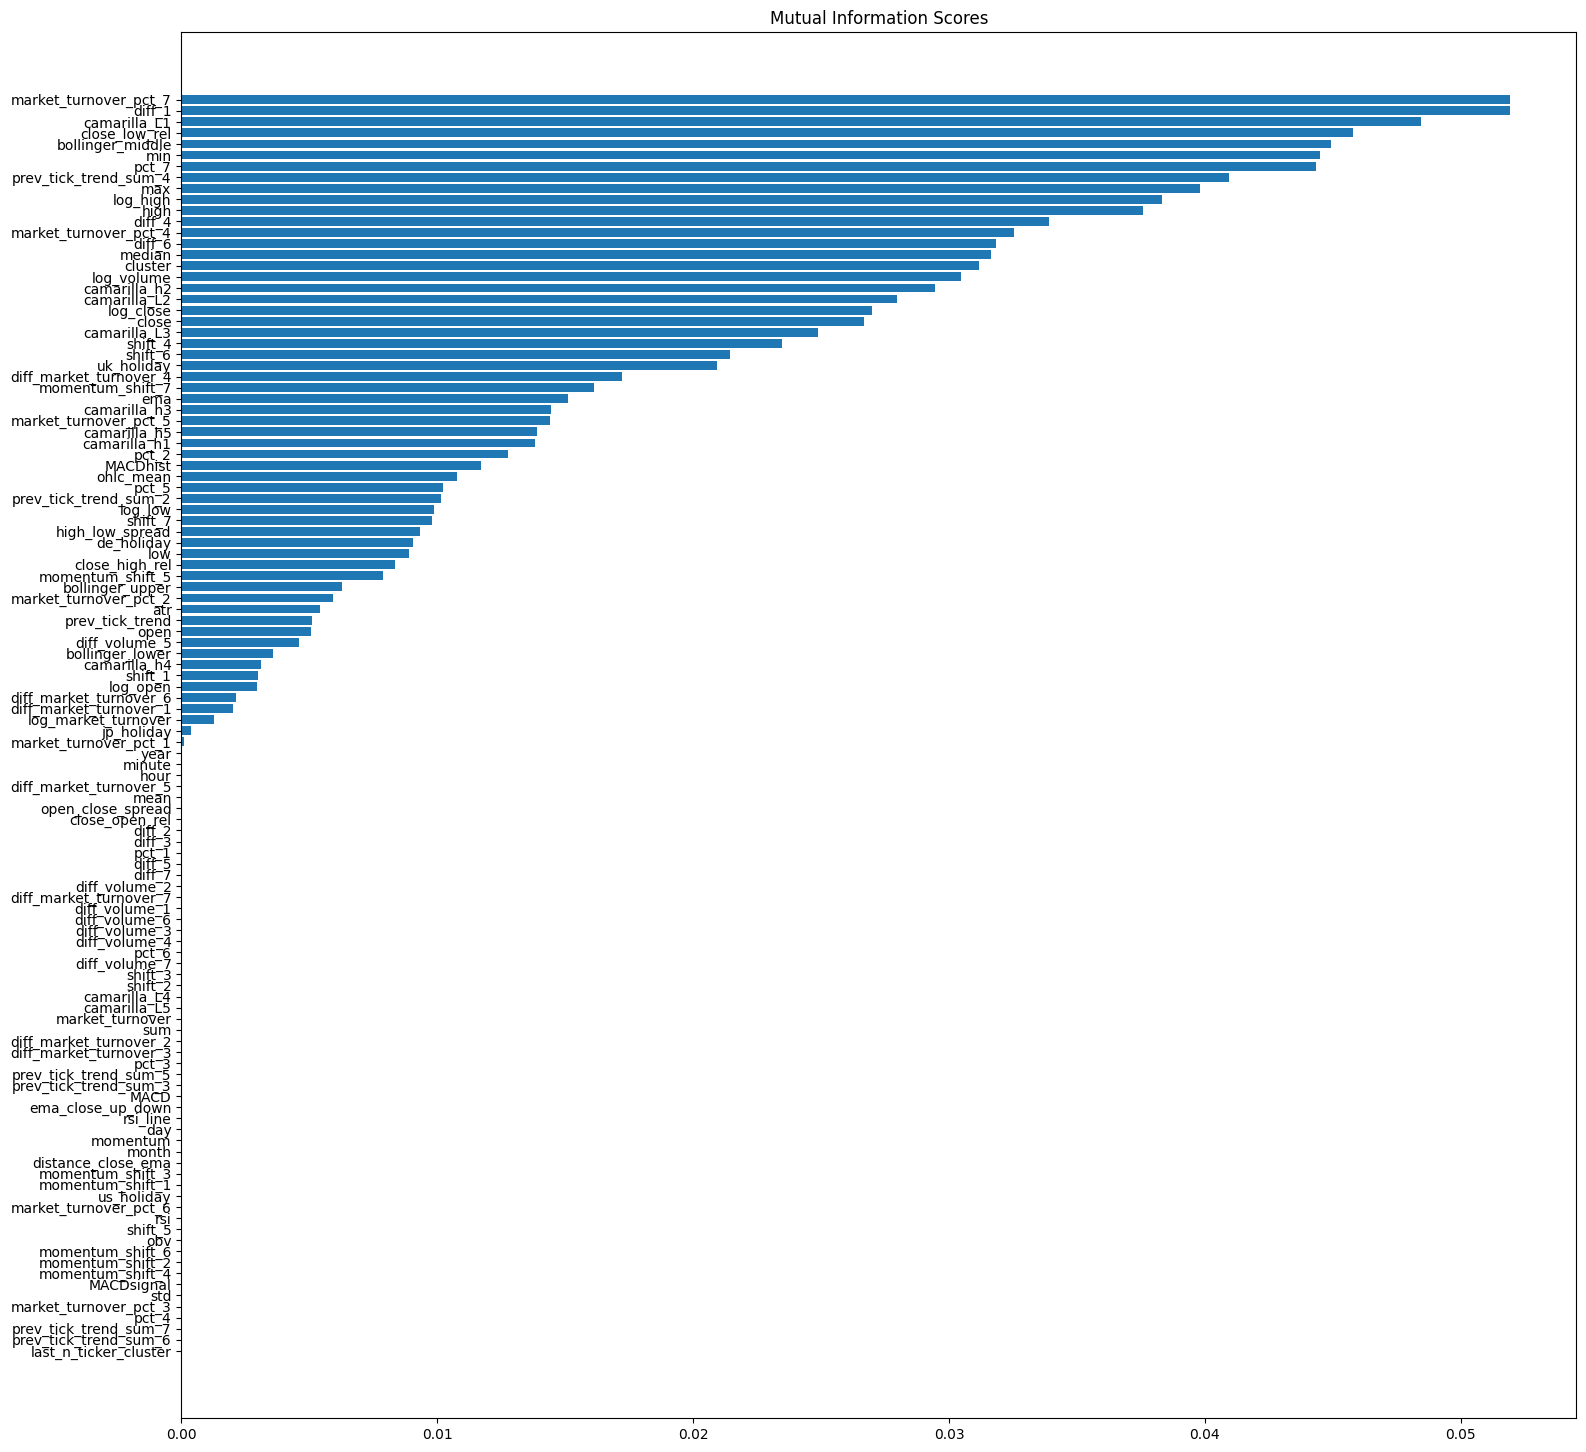

In [7]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


def mi_scores(df, targets_fields):
    X = df.copy()
    for i in targets_fields:
        y = X.pop(i)
    X.pop("volume") # TMP!!!!!

    discrete_features = X.dtypes == int
    mi_scores = make_mi_scores(X, y, discrete_features)    
    print(f"** Mutual info score **")
    print(mi_scores[:10])

    plt.figure(dpi=100, figsize=(18, 18))
    plot_mi_scores(mi_scores)

mi_scores(data, targets)

                       y_next_trend
close                     -0.145471
high                      -0.146027
low                       -0.150155
open                      -0.151392
volume                    -0.005798
...                             ...
distance_close_ema        -0.039268
rsi_line                  -0.029124
cluster                   -0.028106
last_n_ticker_cluster      0.034082
y_next_trend               1.000000

[116 rows x 1 columns]


<Axes: >

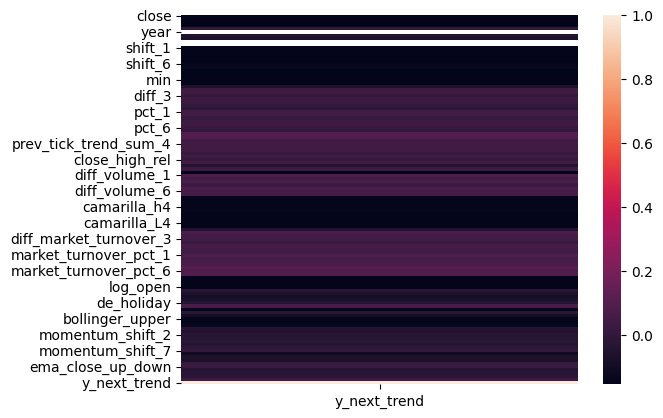

In [8]:
# corr = data.corr("pearson", numeric_only=True)
corr = data.corr(numeric_only=True)
corr = corr.drop(columns=features)
print(corr)
sns.heatmap(corr)

In [9]:
feature: str = "y_next_trend"

In [10]:


fig = px.line(data, y=feature)
fig.show()
fig = px.histogram(data, x=feature)
fig.show()

In [11]:
fig = px.line(data, x=data.index, y='close', labels="close")
fig.add_scatter(x=data.index, y=data[feature], mode='lines')

fig.show()


# Test/Predict

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance


def train_and_evaluate_model_with_decision_tree_classifier(data, feature_cols, target_column, test_months=2):
    test_start_date = data['datetime'].max() - pd.DateOffset(months=test_months)
    train_data = data[data['datetime'] < test_start_date]
    test_data = data[data['datetime'] >= test_start_date]

    
    # Разделение на признаки (X) и целевую переменную (y)
    X_train = train_data[feature_cols]
    y_train = train_data[target_column]
    X_test = test_data[feature_cols]
    y_test = test_data[target_column]
    
    # Модель дерева решений
    clf = DecisionTreeClassifier(max_depth=5, random_state=42)
    clf.fit(X_train, y_train)
    
    # Прогноз вероятностей на тренировочной и тестовой выборках
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    

    # Печать таблицы метрик
    # print(f'{"Train Accuracy  ":<15}'
    #       f'{"Test Accuracy   ":<15}')
    # print("-" * 50)   
    
    # print(f'{accuracy_score(y_train, y_train_pred):<15.2f} {accuracy_score(y_test, y_test_pred):<15.2f}')
    print("DecisionTreeClassifier")
    print(f'Train Accuracy: {accuracy_score(y_train, y_train_pred):.2f}')
    print(f'Test Accuracy: {accuracy_score(y_test, y_test_pred):.2f}')

    perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)
    feature_importance = perm_importance.importances_mean

    # Расчет метрик для случайного предсказания
    p=[1 - abs(y_test.mean()), abs(y_test.mean())]
    random_pred = np.random.choice([-1, 1], size=len(y_test), p=p)
    
    print("\nMetrics for Random Predictions:")
    print(f'Accuracy: {accuracy_score(y_test, random_pred):.2f}')

    return clf, feature_importance


In [13]:
data_for_predict: pd.DataFrame = pd.read_csv(f"data/{dsn}")
data_for_predict['datetime'] = pd.to_datetime(data_for_predict['datetime'])

model, feature_importance_perm = train_and_evaluate_model_with_decision_tree_classifier(data_for_predict, features, "y_next_trend")

DecisionTreeClassifier
Train Accuracy: 0.81
Test Accuracy: 0.56

Metrics for Random Predictions:
Accuracy: 0.60


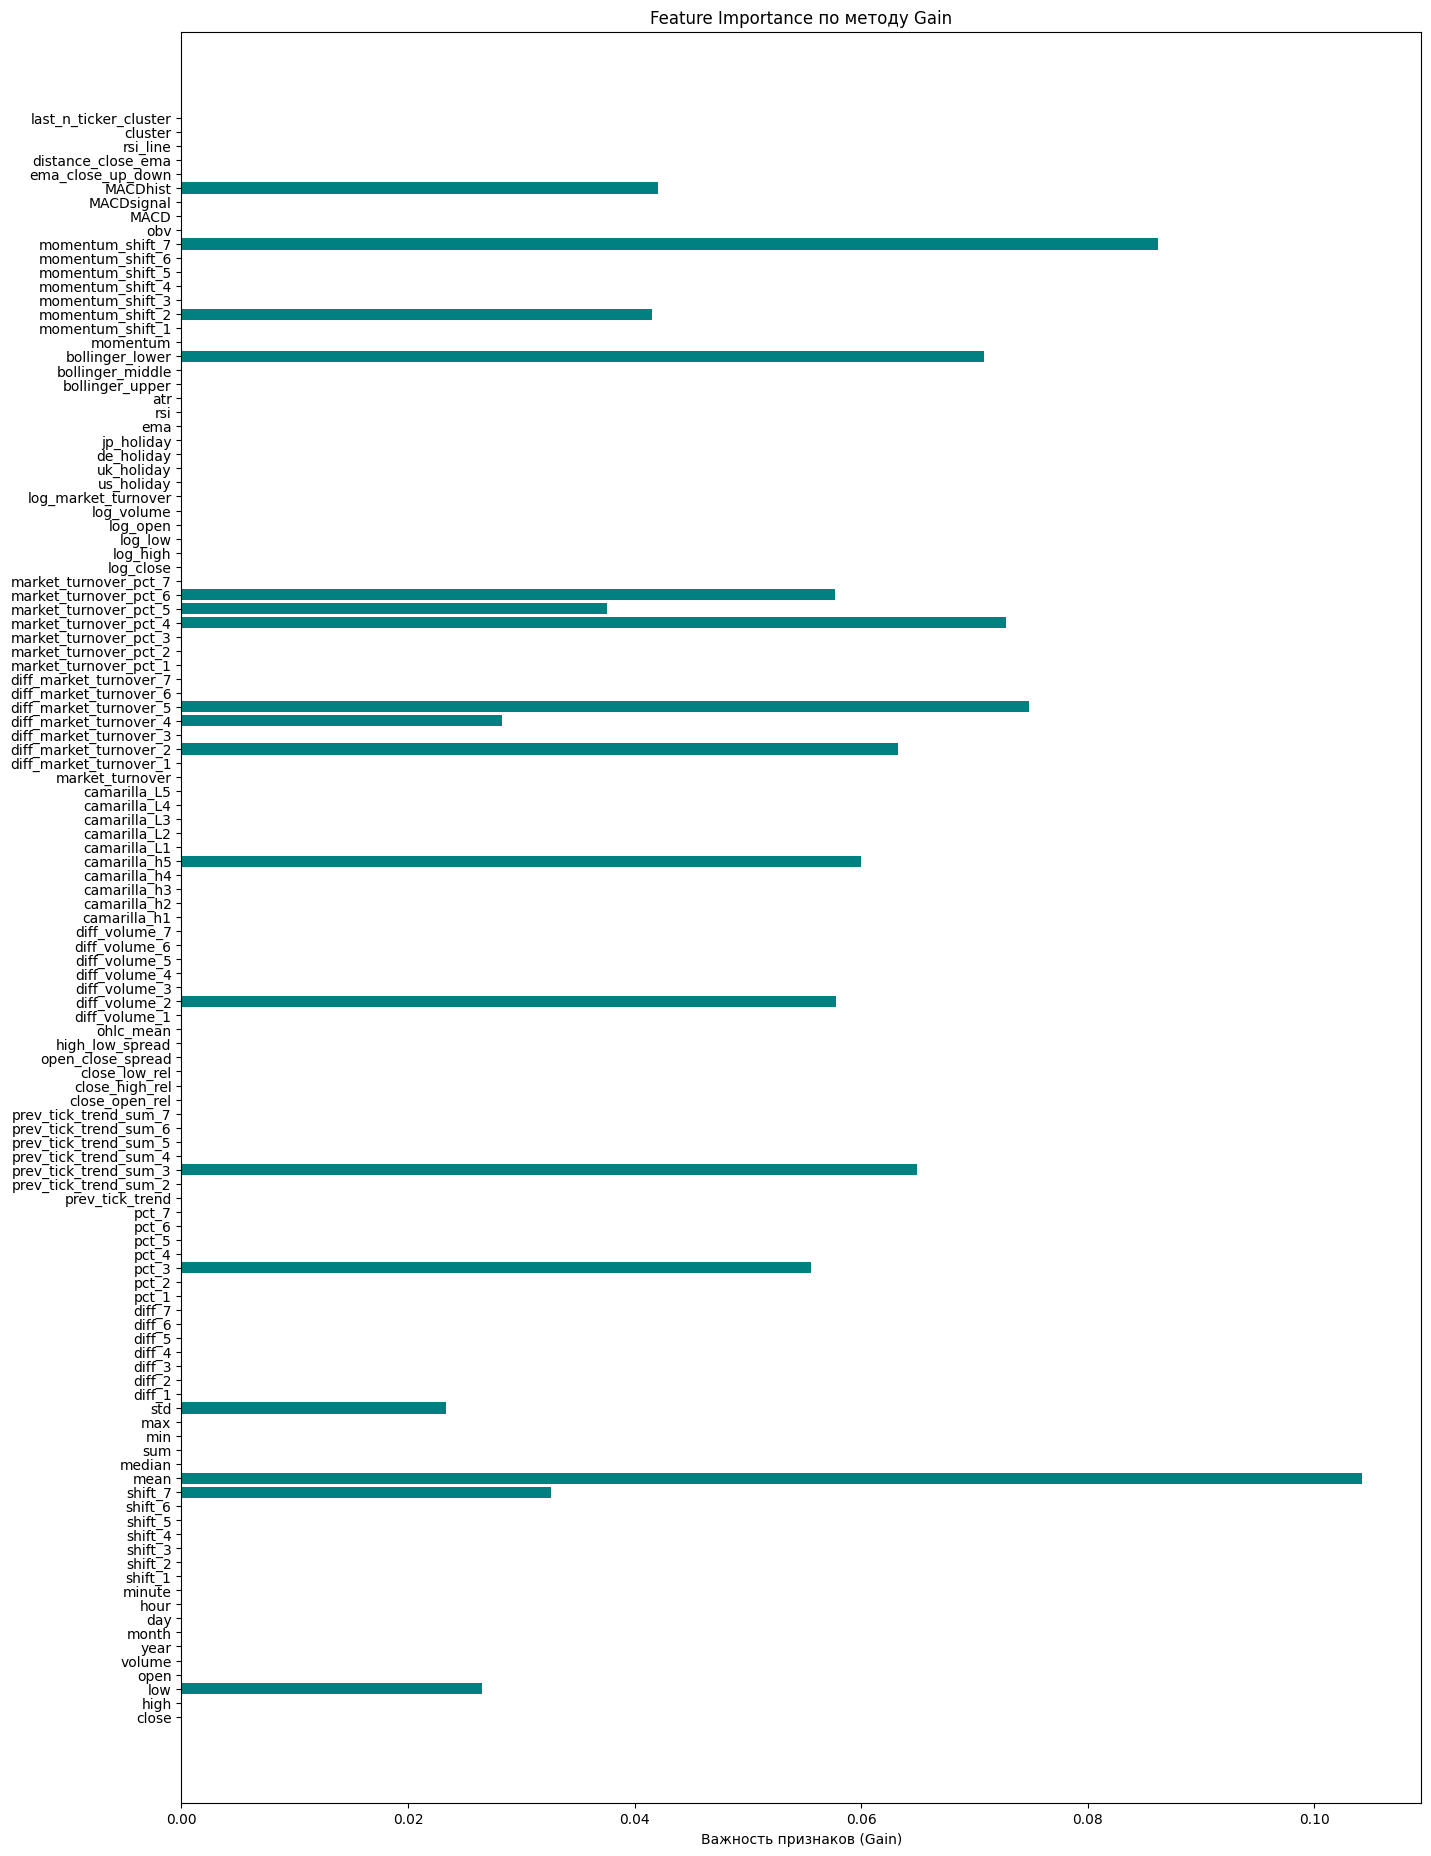

In [14]:
# Оценка важности признаков по методу Gain
feature_importance = model.feature_importances_

# Визуализация feature importance
plt.figure(figsize=(16, 23))
plt.barh(features, feature_importance, color='teal')
plt.xlabel('Важность признаков (Gain)')
plt.title('Feature Importance по методу Gain')
plt.show()

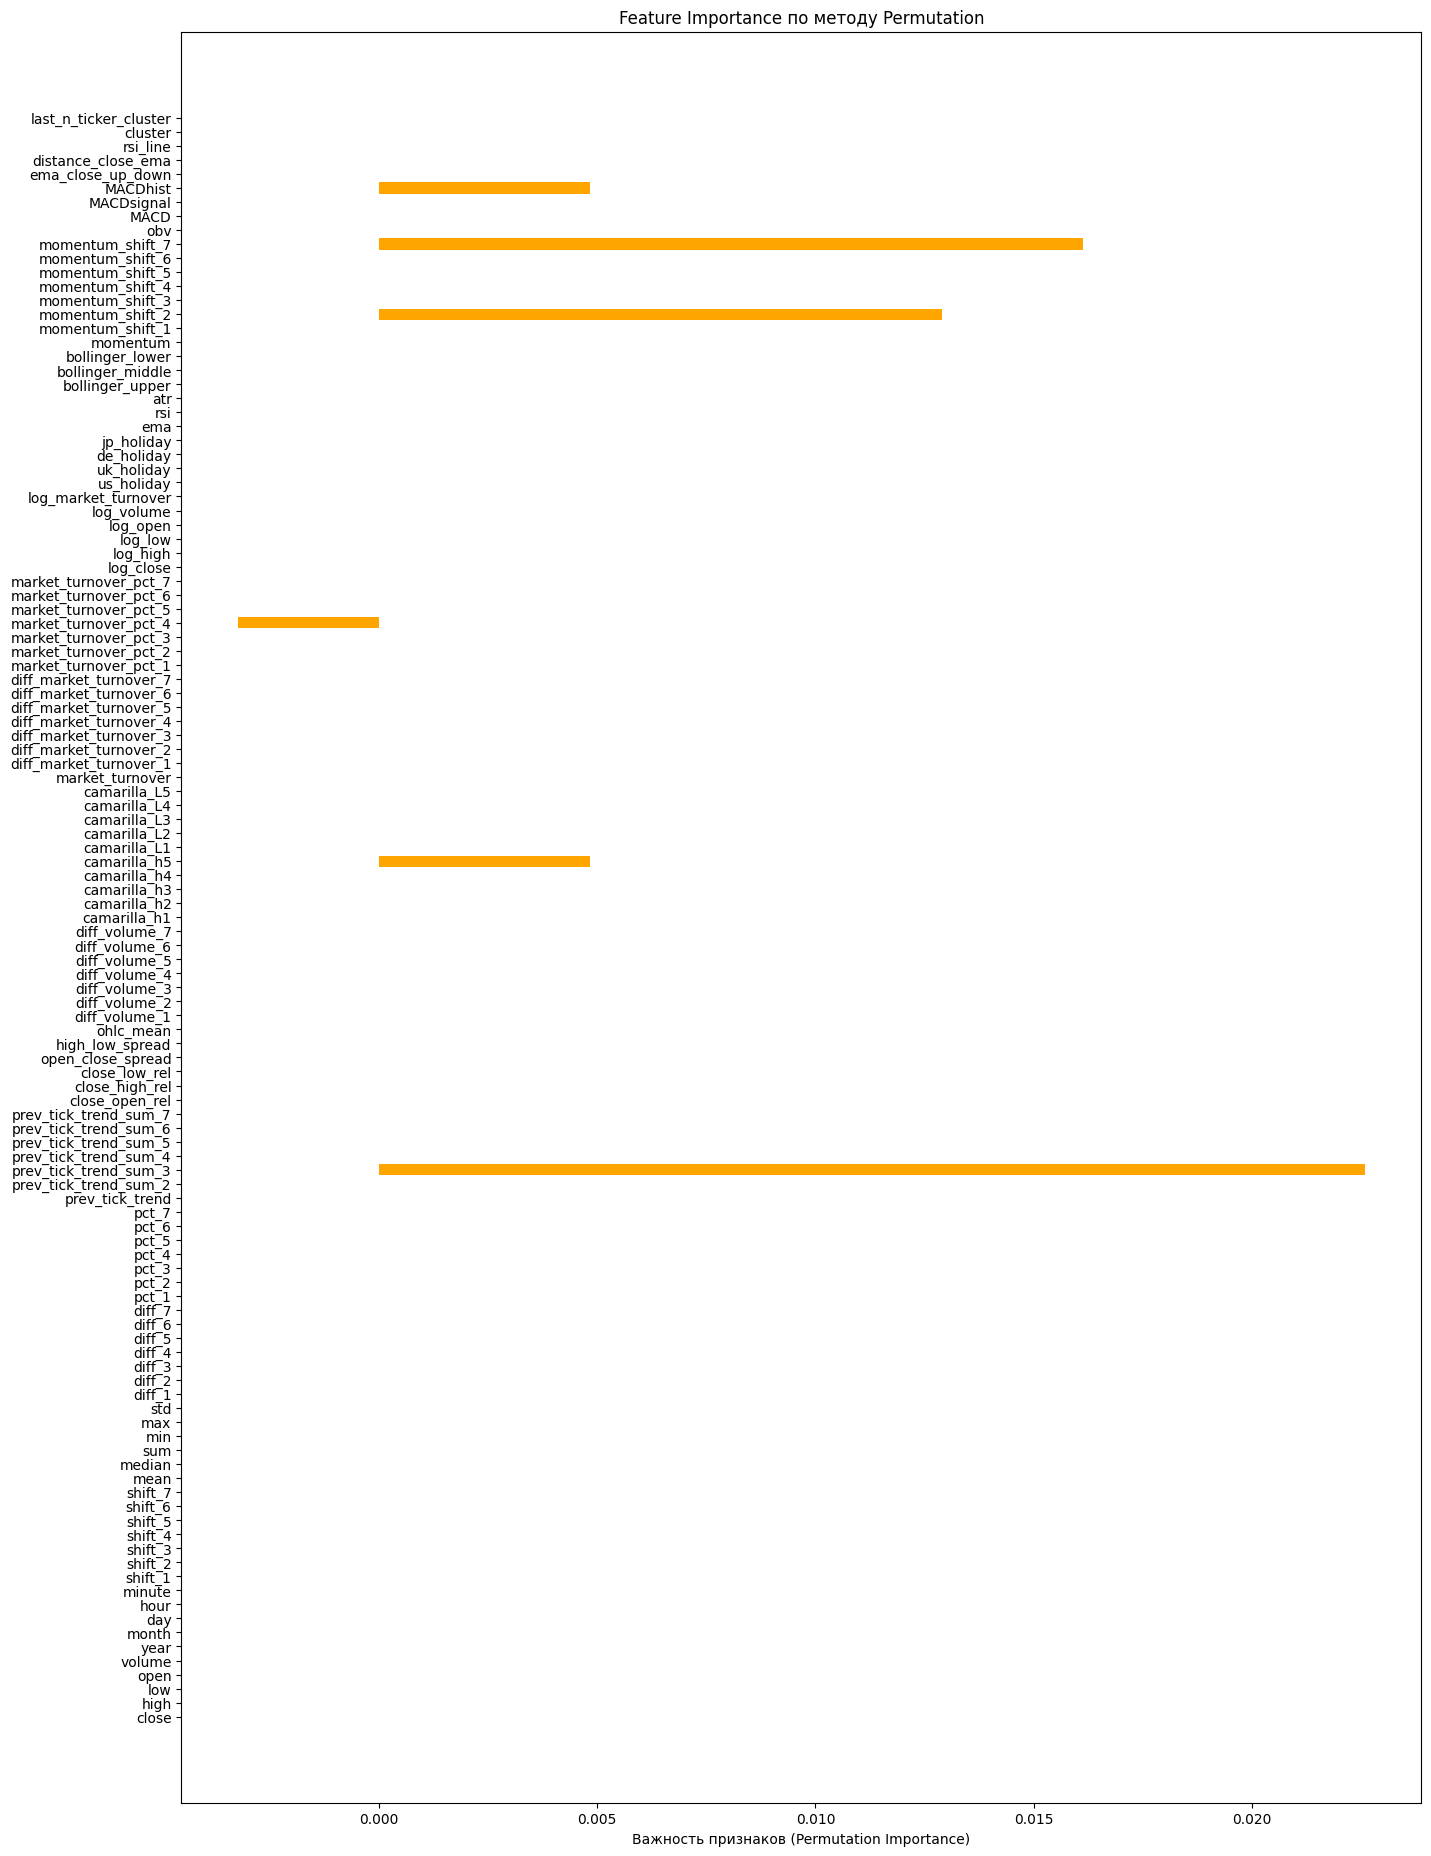

In [15]:
# Оценка важности признаков по методу Permutation Importance

# Визуализация feature importance
plt.figure(figsize=(16, 23))
plt.barh(features, feature_importance_perm, color='orange')
plt.xlabel('Важность признаков (Permutation Importance)')
plt.title('Feature Importance по методу Permutation')
plt.show()